In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

### Resistance data

In [2]:
resistance_data = pd.read_csv('antibio_dataset/resist.csv')

In [3]:
resistance_data.shape

(3786, 4)

Missing values per column:

In [4]:
resistance_data.isna().sum()

Sample_ID      0
azm_sr       308
cip_sr       698
cfx_sr       385
dtype: int64

Proportion of missing values per column:

In [5]:
resistance_data.isna().sum() / len(resistance_data)

Sample_ID    0.000000
azm_sr       0.081352
cip_sr       0.184363
cfx_sr       0.101690
dtype: float64

Although the share of missing values per column is not significantly high, one would still aim to keep as much data points as possible for the prediction analysis. Thus imputation of missing values would be a possible step but in this case the authors hold no information about the biological similarity of the samples. Not being certain if Sample_ID string similarity would also translate into biological dimilarity between the samples, authors decided not to impute the missing values without additional similarity measures and omit the samples that have missing values from the analysis entirely.

In [6]:
azithromycin_res = resistance_data[resistance_data['azm_sr'].isna() != True][['Sample_ID','azm_sr']]
cefixime_res = resistance_data[resistance_data['cfx_sr'].isna() != True][['Sample_ID','cfx_sr']]
ciprofloxacin_res = resistance_data[resistance_data['cip_sr'].isna() != True][['Sample_ID','cip_sr']]

In [7]:
print(f"Azithromycin: {azithromycin_res.shape[0]} samples")
print(f"Cefixime: {cefixime_res.shape[0]} samples")
print(f"Ciprofloxacin: {ciprofloxacin_res.shape[0]} samples")

Azithromycin: 3478 samples
Cefixime: 3401 samples
Ciprofloxacin: 3088 samples


### K-mer data

In [8]:
kmers_azithromycin = pd.read_csv('antibio_dataset/kmers_azithromycin.tsv', sep="\t")
kmers_cefixime = pd.read_csv('antibio_dataset/kmers_cefixime.tsv', sep="\t")
kmers_ciprofloxacin = pd.read_csv('antibio_dataset/kmers_ciprofloxacin.tsv', sep="\t")

In [9]:
kmers_azithromycin.head()

,pattern_id,ERR1549286,ERR1549290,ERR1549291,ERR1549287,ERR1549288,ERR1549299,ERR1549292,ERR1549298,ERR1549296,...,ERR2172345,ERR2172346,ERR2172347,ERR2172348,ERR2172349,ERR2172350,ERR2172351,ERR2172352,ERR2172353,ERR2172354
0,CTTAACATATTTGCCTTTGATTTTTGAAGAAGCTGCCACGCCGGCAG,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,TACCGTAACCGGCAATGCGGATATTACGGTC,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,CAGACGGCATTTTTTTTGCGTTTTTCGGGAGG,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
3,AACGGGTTTTCAGACGGCATTCGATATCGGGACG,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,CCAAAAATTACCCGCGTTGACGTAGCTAAAGA,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In order to merge the information of the resistance data tables and k-mer data tables, the k-mer tables need to be transposed (sample IDs in rows and patterns in columns).

#### Azithromycin

In [10]:
kmers_azithromycin = kmers_azithromycin.transpose()

#Making the first row of the transposed DataFrame as column headers
new_header = kmers_azithromycin.iloc[0]
kmers_azithromycin = kmers_azithromycin[1:] 
kmers_azithromycin.columns = new_header

#Making the structure of column names similar to the structure of resistance tables
kmers_azithromycin = kmers_azithromycin.reset_index()
kmers_azithromycin = kmers_azithromycin.rename(columns={'index': 'Sample_ID'})
kmers_azithromycin.index.name = None

#### Cefixime

In [11]:
kmers_cefixime = kmers_cefixime.transpose()

#Making the first row of the transposed DataFrame as column headers
new_header = kmers_cefixime.iloc[0]
kmers_cefixime = kmers_cefixime[1:] 
kmers_cefixime.columns = new_header

#Making the structure of column names similar to the structure of resistance tables
kmers_cefixime = kmers_cefixime.reset_index()
kmers_cefixime = kmers_cefixime.rename(columns={'index': 'Sample_ID'})
kmers_cefixime.index.name = None

#### Ciprofloxacin

In [12]:
kmers_ciprofloxacin = kmers_ciprofloxacin.transpose()

#Making the first row of the transposed DataFrame as column headers
new_header = kmers_ciprofloxacin.iloc[0]
kmers_ciprofloxacin = kmers_ciprofloxacin[1:] 
kmers_ciprofloxacin.columns = new_header

#Making the structure of column names similar to the structure of resistance tables
kmers_ciprofloxacin = kmers_ciprofloxacin.reset_index()
kmers_ciprofloxacin = kmers_ciprofloxacin.rename(columns={'index': 'Sample_ID'})
kmers_ciprofloxacin.index.name = None

### Merging the data

In [13]:
azithromycin_data = kmers_azithromycin.merge(azithromycin_res, how = 'right', on = 'Sample_ID')
cefixime_data = kmers_cefixime.merge(cefixime_res, how = 'right', on = 'Sample_ID')
ciprofloxacin_data = kmers_ciprofloxacin.merge(ciprofloxacin_res, how = 'right', on = 'Sample_ID')

Visualising the frequency of different k-mers

In [28]:
azithromycin_column_sums = np.sum(azithromycin_data.iloc[:,1:-1], axis=0)
cefixime_column_sums = np.sum(cefixime_data.iloc[:,1:-1], axis=0)
ciprofloxacin_column_sums = np.sum(ciprofloxacin_data.iloc[:,1:-1], axis=0)

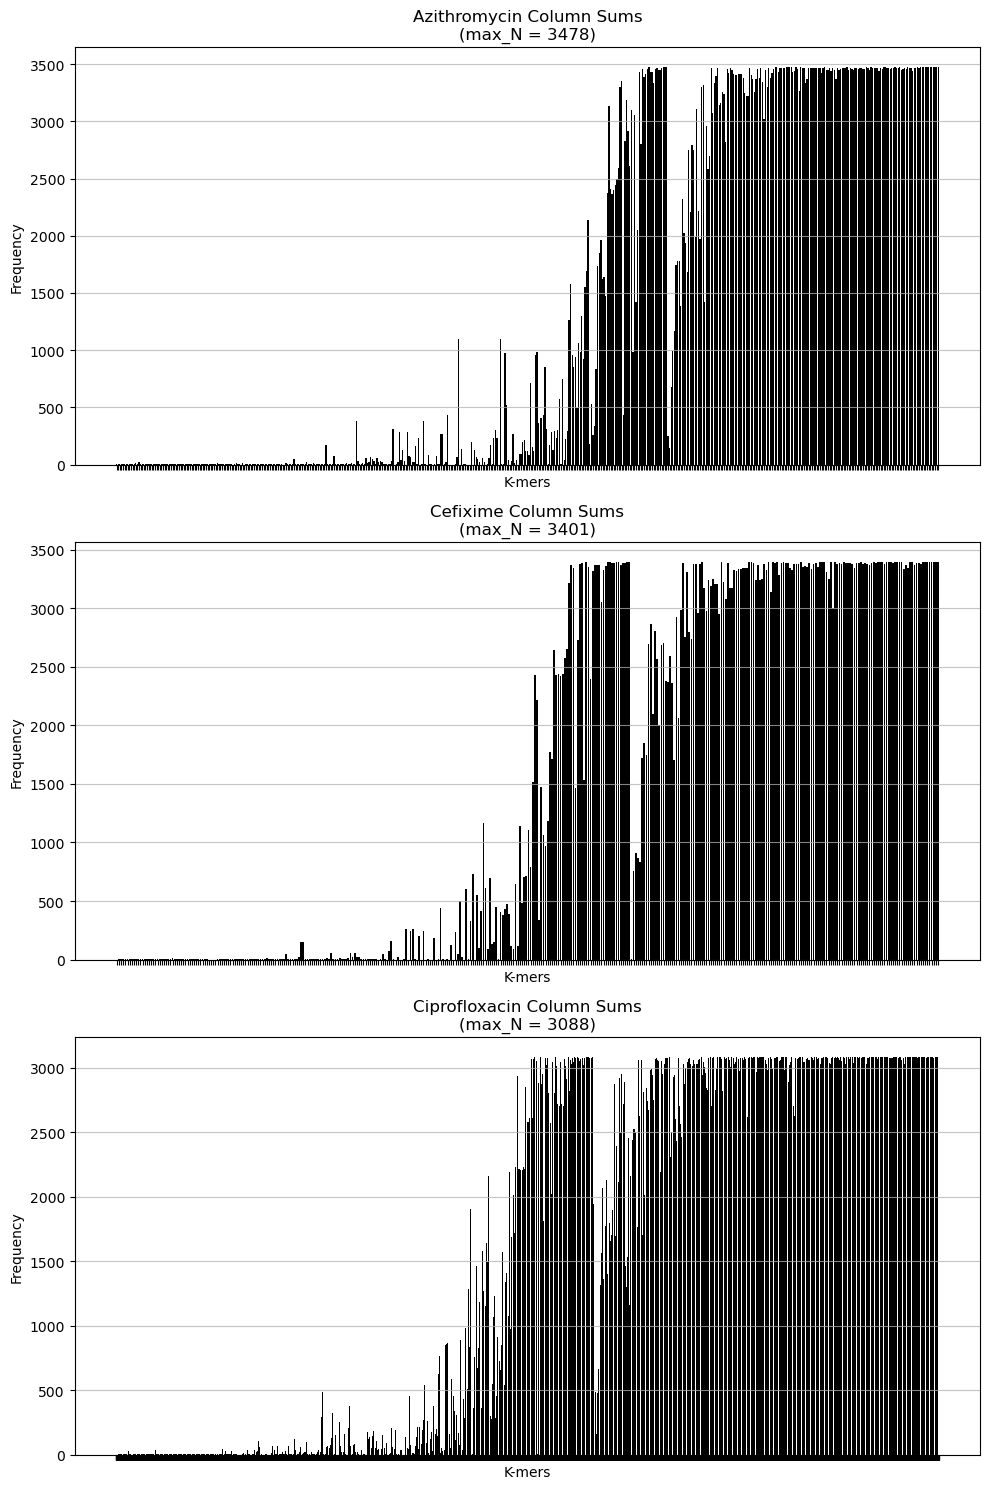

In [55]:
# Plotting histograms
fig, axs = plt.subplots(3, 1, figsize=(10, 15))

axs[0].bar(azithromycin_data.iloc[:,1:-1].columns , azithromycin_column_sums, color = 'black')
axs[0].set_title(f'Azithromycin Column Sums\n(max_N = {len(azithromycin_data)})')
axs[0].set_xlabel('K-mers')
axs[0].set_ylabel('Frequency')
axs[0].grid(axis='y', alpha=0.75)
axs[0].tick_params(axis='x', labelbottom=False)

axs[1].bar(cefixime_data.iloc[:,1:-1].columns , cefixime_column_sums, color = 'black')
axs[1].set_title(f'Cefixime Column Sums\n(max_N = {len(cefixime_data)})')
axs[1].set_xlabel('K-mers')
axs[1].set_ylabel('Frequency')
axs[1].grid(axis='y', alpha=0.75)
axs[1].tick_params(axis='x', labelbottom=False)

axs[2].bar(ciprofloxacin_data.iloc[:,1:-1].columns , ciprofloxacin_column_sums, color = 'black')
axs[2].set_title(f'Ciprofloxacin Column Sums\n(max_N = {len(ciprofloxacin_data)})')
axs[2].set_xlabel('K-mers')
axs[2].set_ylabel('Frequency')
axs[2].grid(axis='y', alpha=0.75)
axs[2].tick_params(axis='x', labelbottom=False)

plt.tight_layout()
plt.show()